In [177]:
# Initial imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import requests
import datetime
from datetime import datetime, timedelta, date
from dateutil.parser import parse
import matplotlib.pyplot as plt

#Alpaca API imports
import alpaca_trade_api as tradeapi

#Twitter API imports
import tweepy as tw

# NLP & Sentiment imports
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

from dotenv import load_dotenv
load_dotenv()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Kris/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [178]:
############################################################
"""
    Authenticates the Alpaca API and Twitter
    Returns a pass/fail statement
"""
############################################################  
    
# Setting twitter access and api keys
bearer_token = os.getenv("TWITTER_BEARER_TOKEN")
consumer_key= os.getenv("TWITTER_API_KEY")
consumer_secret= os.getenv("TWITTER_SECRET_KEY")
access_token= os.getenv("TWITTER_ACCESS_TOKEN")
access_token_secret= os.getenv("TWITTER_ACCESS_TOKEN_SECRET")

# authentication for twitter
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
twitter_api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# test authentication
try:
    twitter_api.verify_credentials()
    auth = "Twitter Authentication Verified"
except:
    auth = "Error During Twitter Authentication"
    
print(auth)

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
alpaca_api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

Twitter Authentication Verified


In [201]:
############################################################
"""
   Reads in a CSV of data and returns a data frame.
"""
############################################################

def read_csv(path):

    csvpath = Path(path)
    df = pd.read_csv(csvpath, parse_dates=True, index_col="date", infer_datetime_format=True)
    df.drop(columns=["Unnamed: 0", "tweet","positive","negative", "neutral"], inplace=True)
    avg_df = df.groupby(pd.Grouper(level=0, freq='15min')).mean().dropna()

    
    return avg_df

############################################################
"""
    Cleans the tweets and removes the included url
    
    Note: Did not use this function in the end, as VADER
    does better with punctuation, emojis, and CAPS.
"""
############################################################

def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())



############################################################
"""
    Sentiment calculation based on compound score
"""
############################################################

def get_normalized(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.04:  # Positive
        result = 1
    elif score <= -0.04:  # Negative
        result = -1

    return result


############################################################
"""
    Function that pulls stock data from a given ticker and timeframe.
"""
############################################################

def daily_returns(ticker, timeframe):
        
    # Set current date and the date from one month ago using the ISO format
    current_date = pd.Timestamp.now(tz="America/New_York").isoformat()
    past_date = pd.Timestamp("2021-01-01 00:00", tz="America/New_York").isoformat()

    # Get 4 weeks worth of historical data for AAPL
    df = alpaca_api.get_barset(
        ticker=ticker,
        timeframe=timeframe,
        limit=None,
        start=past_date,
        end=current_date,
        after=None,
        until=None,
    ).df
        
    return df



############################################################
"""
    Twitter: Scrape Tweets and Analyze Sentiment
"""
############################################################

def twitter_sentiment(search_words, date_since, items):
       
    # Initialize the VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()

    # initializing the tweets dataframe
    df = []
    
    # adding retweet filter to search words
    search_words = search_words + " -filter:retweets"
    
    # Fetch top tweets/hastags for given ticker
    tweets = tw.Cursor(twitter_api.search,
              q=search_words,
              lang="en",
              since=date_since
                    ).items(items)
    
    for tweet in tweets:
    
        tweet_fetched = tweet.text 
        #Clean text of tweets
        #remove_url(tweet.text)

        # Get date of tweet
        tweet_date = pd.Timestamp(tweet.created_at, tz="America/New_York").isoformat()
        
        try:
            sentiment = analyzer.polarity_scores(tweet_fetched)
            compound = sentiment["compound"]
            #pos = sentiment["pos"]
            #neu = sentiment["neu"]
            #neg = sentiment["neg"]
        
            df.append({
                "date": tweet_date,
                "tweet": tweet_fetched,
                "compound": compound,
                #"positive": pos,
                #"negative": neg,
                #"neutral": neu
            
            })
        
        except AttributeError:
            pass
    
    df = pd.DataFrame(df)
    
    return df



############################################################
"""
    get_twitter_sentiment(search_words):
    Takes 1 argument, word(s) to search tweets for.
    
    Scrapes Twitter for given search words in tweet
    Calculates compound sentiment with VADER sentiment analyzer on each tweet
    Calculates average compound sentiment score each 1 hour
    Normalizes average hourly VADER compound score
    Returns Average Hourly Sentiment Dataframe with Columns: 
"""
############################################################

def get_avg_sentiment(search_words):

    # tweepy variables
    search_words = search_words
    date_since = "2021-01-01"
    items = 10000

    # call the twitter sentiment function and return a dataframe
    tweets_df = twitter_sentiment(search_words, date_since, items)

    # Changes the date column to proper datetime format
    tweets_df['date'] = pd.to_datetime(tweets_df['date'])
    
    # Code below didn't produce proper result downstream - saving for reference
    # Creates datetime object and outputs only the Date and Hour for each tweet
    # tweets_df['date'] = tweets_df['date'].apply(lambda x: pd.Timestamp(x).strftime('%m-%d-%Y %H'))

    # Save raw tweets dataframe to csv
    # Next steps, 
        # 1. Scan folder to see if csv file of user input ticker exists
        # 2. Create the new filename as a user input variable if csv does not exist
        # 3. If csv file already exists, open, append new date rows, save, close.
    # tweets_df.to_csv(r'C:\Users\Kris\Documents\ucb_fintech\Homework\Project2\tweets\msft_tweets.csv')
    
    # Grouping the tweets by Hour and taking their average Hourly sentiment
    avg_hourly_sentiment = tweets_df.groupby(pd.Grouper(key='date', freq='H')).mean().dropna()
    
    # Get the normalized sentiment score of -1, 0, 1
    avg_hourly_sentiment["normalized"] = avg_hourly_sentiment["compound"].apply(lambda x : get_normalized(x))
    
    return avg_hourly_sentiment


############################################################
"""
    get_ticker_data(ticker):
    Takes 1 argument, ticker to search tweets for.
    
    Scrapes Twitter for given search words.
    Calculates compound sentiment with VADER sentiment analyzer 
    Normalizes VADER compound score
    Returns Average Daily Sentiment Dataframe with Columns: 
"""
############################################################

def get_ticker_data(ticker, timeframe):
    
    # alpaca api variables
    ticker = ticker
    timeframe = timeframe

    # call the alpaca api and return a dataframe of daily returns
    daily_df = daily_returns(ticker, timeframe)

    # Drop Outer Table Level and drop extra columns
    daily_df = daily_df.droplevel(axis=1, level=0)
    daily_df = daily_df.drop(columns=["open", "high", "low", "volume"])

    # Get the percent change of the closing prices, drop any NA rows, and reset the index
    daily_df["percent_change"] = daily_df.pct_change().dropna()
    #returns_df = daily_df.pct_change().dropna()

    # Grouping the tweets by Hour and taking their average Hourly sentiment
    #avg_returns = daily_df.groupby(pd.Grouper(key='time', freq='5min')).mean().dropna()
    
    return daily_df



############################################################
"""
    combine_sentiment_with_close(avg_hourly_returns, avg_hourly_sentiment):
    Takes 2 arguments: the two dataframes to combine
"""
############################################################

def combine_sentiment_with_close(avg_hourly_sentiment, avg_hourly_returns):

    # Combines the average hourly Twitter sentiment dataframe with the hourly percent change dataframe
    combined_df = avg_hourly_returns.join(avg_hourly_sentiment).dropna()
    
    return combined_df



############################################################
"""
    main_function:
    Defines the main function.
    1 argument: search word to search twitter and stock prices.
"""
############################################################

def main_function(twitter_search_word, ticker, timeframe):
    
    # calling csv function to read in stored data
    # twitter_sentiment = read_csv("tweets/msft_tweets.csv")
    
    twitter_sentiment = get_avg_sentiment(twitter_search_word)
    percent_change = get_ticker_data(ticker, timeframe)
    combined_df = combine_sentiment_with_close(twitter_sentiment, percent_change)
    
    
    return combined_df

In [167]:
twitter_search_word = "microsoft" # to be updated to %store -r search_word
ticker = "MSFT" # to be updated to %store -r ticker

combined_df = main_function(twitter_search_word, ticker)
combined_df

,close,compound
time,,
2021-01-11 13:40:00+00:00,-0.007879,0.220200
2021-01-11 13:55:00+00:00,-0.001148,-0.038600
2021-01-11 14:15:00+00:00,0.000919,0.726900
2021-01-11 14:20:00+00:00,-0.000918,0.226933
2021-01-11 14:30:00+00:00,-0.000873,0.115350
2021-01-11 14:35:00+00:00,0.002415,-0.296000
2021-01-11 14:40:00+00:00,-0.003051,0.372800
2021-01-11 14:45:00+00:00,-0.000046,0.000000
2021-01-11 14:55:00+00:00,-0.000988,0.440400


In [356]:
#reading in a prepping the training data using a frequency of 15-minute time intervals
# pd.set_option("display.max_rows", 50, "display.max_columns", 50)

twitter_search_word = "microsoft" 
ticker = "MSFT" 
timeframe = "5Min"
freq = "5min"

csvpath = Path("tweets/msft_tweets.csv")
df = pd.read_csv(csvpath, parse_dates=True, index_col="date", infer_datetime_format=True)
df.drop(columns=["Unnamed: 0", "tweet","positive","negative", "neutral"], inplace=True)
avg_df = df.groupby(pd.Grouper(level=0, freq=freq)).mean().dropna()

percent_change = get_ticker_data(ticker, timeframe)
combined_df = percent_change.join(avg_df).dropna()
combined_df.sort_values(by="time", axis=0, ascending=False)

,close,percent_change,compound
time,,,
2021-01-15 21:30:00+00:00,212.41,-0.000847,0.250738
2021-01-15 20:55:00+00:00,212.59,-0.001597,-0.038529
2021-01-15 20:50:00+00:00,212.93,-0.001454,0.186680
2021-01-15 20:45:00+00:00,213.24,0.000375,0.386329
2021-01-15 20:40:00+00:00,213.16,-0.001826,0.025740
...,...,...,...
2021-01-11 14:30:00+00:00,217.41,-0.000873,0.115350
2021-01-11 14:20:00+00:00,217.60,-0.000918,0.226933
2021-01-11 14:15:00+00:00,217.80,0.000919,0.726900


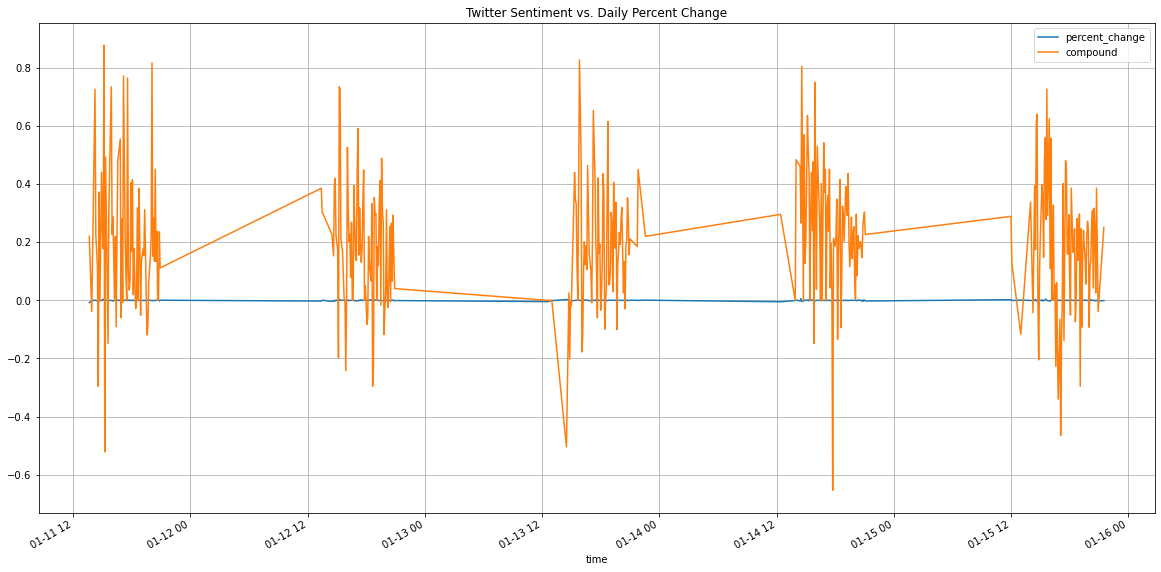

In [269]:
combined_df.plot(
    y=["percent_change","compound"],
    kind="line",
    title= "Twitter Sentiment vs. Daily Percent Change",
    figsize= (20,10),
    grid=True,
);

In [270]:
# Get descriptive stats from the DataFrame
combined_df.describe()

,close,percent_change,compound
count,388.000000,388.000000,388.000000
mean,215.352031,-0.000095,0.193555
std,1.615536,0.001225,0.224614
min,212.185000,-0.007879,-0.654150
25%,213.970000,-0.000674,0.037633
50%,215.122500,0.000000,0.186740
75%,216.397500,0.000513,0.313176
max,218.820000,0.005792,0.877900


In [271]:
# Correlate the twitter sentiment to returns
combined_df.corr().style.background_gradient()

,close,percent_change,compound
close,1.000000,0.044818,0.070830
percent_change,0.044818,1.000000,-0.057820
compound,0.070830,-0.057820,1.000000


In [322]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    
    `df`: The original DataFrame with the time series data.
    `window`: The window size in days of previous closing prices that will be used for the prediction.
    `feature_col_number`: The column number from the original DataFrame where the features are located.
    `target_col_number`: The column number from the original DataFrame where the target is located.
  
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [337]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 5

feature_column = 2
target_column = 1

X, y = window_data(combined_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[ 0.2202     -0.0386      0.7269      0.22693333  0.11535   ]
 [-0.0386      0.7269      0.22693333  0.11535    -0.296     ]
 [ 0.7269      0.22693333  0.11535    -0.296       0.3728    ]
 [ 0.22693333  0.11535    -0.296       0.3728      0.        ]
 [ 0.11535    -0.296       0.3728      0.          0.4404    ]] 

y sample values:
[[ 2.41479233e-03]
 [-3.05136853e-03]
 [-4.60256823e-05]
 [-9.87915269e-04]
 [ 1.49483706e-03]]


In [338]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [339]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [340]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.57070592]
  [0.40178193]
  [0.90143925]
  [0.5751009 ]
  [0.5022682 ]]

 [[0.40178193]
  [0.90143925]
  [0.5751009 ]
  [0.5022682 ]
  [0.23377174]]

 [[0.90143925]
  [0.5751009 ]
  [0.5022682 ]
  [0.23377174]
  [0.67031102]]

 [[0.5751009 ]
  [0.5022682 ]
  [0.23377174]
  [0.67031102]
  [0.42697693]]

 [[0.5022682 ]
  [0.23377174]
  [0.67031102]
  [0.42697693]
  [0.71443491]]] 

X_test sample values:
[[[0.54890506]
  [0.57070592]
  [0.65433243]
  [0.33953418]
  [0.52418002]]

 [[0.57070592]
  [0.65433243]
  [0.33953418]
  [0.52418002]
  [0.62608923]]

 [[0.65433243]
  [0.33953418]
  [0.52418002]
  [0.62608923]
  [0.69837799]]

 [[0.33953418]
  [0.52418002]
  [0.62608923]
  [0.69837799]
  [0.36551866]]

 [[0.52418002]
  [0.62608923]
  [0.69837799]
  [0.36551866]
  [0.46860416]]]


In [341]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.1

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [342]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [343]:
# Summarize the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 5, 5)              220       
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 5)              0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_17 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [344]:
# Train the model
model.fit(X_train, y_train, epochs=15, shuffle=False, batch_size=2, verbose=1)

Epoch 1/15
134/134 [==============================] - 4s 5ms/step - loss: 0.1153
Epoch 2/15
134/134 [==============================] - 1s 4ms/step - loss: 0.0216
Epoch 3/15
134/134 [==============================] - 1s 4ms/step - loss: 0.0192
Epoch 4/15
134/134 [==============================] - 1s 4ms/step - loss: 0.0172
Epoch 5/15
134/134 [==============================] - 1s 4ms/step - loss: 0.0162
Epoch 6/15
134/134 [==============================] - 1s 4ms/step - loss: 0.0143
Epoch 7/15
134/134 [==============================] - 1s 4ms/step - loss: 0.0172
Epoch 8/15
134/134 [==============================] - 1s 4ms/step - loss: 0.0179
Epoch 9/15
134/134 [==============================] - 1s 4ms/step - loss: 0.0165
Epoch 10/15
134/134 [==============================] - 1s 5ms/step - loss: 0.0152
Epoch 11/15
134/134 [==============================] - 1s 5ms/step - loss: 0.0164
Epoch 12/15
134/134 [==============================] - 1s 4ms/step - loss: 0.0147
Epoch 13/15
134/134 [====

In [345]:
# Evaluate the model
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 3ms/step - loss: 0.0114


0.011380014941096306

In [346]:
# Make some predictions
predicted = model.predict(X_test)

In [347]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [348]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.sort_values(by="date", axis=0, ascending=True)

,Real,Predicted
date,,
2021-01-09 03:24:31-05:00,-0.000847,-0.000111
2021-01-09 03:25:00-05:00,-0.001597,-0.000090
2021-01-09 03:25:04-05:00,-0.001454,-0.000123
2021-01-09 03:25:37-05:00,0.000375,-0.000101
2021-01-09 03:26:31-05:00,-0.001826,-0.000094
...,...,...
2021-01-09 09:33:36-05:00,0.000210,-0.000104
2021-01-09 09:51:10-05:00,-0.000444,-0.000161
2021-01-09 09:51:31-05:00,-0.000560,-0.000120


<AxesSubplot:xlabel='date'>

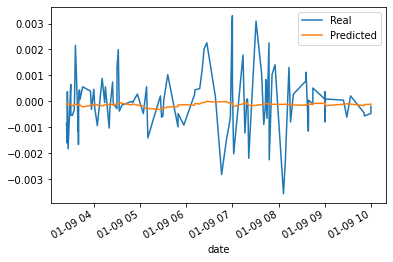

In [349]:
# Plot the real vs predicted prices as a line chart
stocks.plot()

In [350]:
closing_prices = get_ticker_data(ticker, "1D")
last_price = closing_prices.iloc[[-1],[0]]
last_price


,close
time,
2021-01-15 00:00:00-05:00,212.58


In [355]:
stocks["close"] = stocks["Predicted"].apply(lambda x : (x*(closing_prices.iloc[[-1]])))
stocks                                      

,Real,Predicted,close
date,,,
2021-01-09 10:00:01-05:00,-0.000187,-0.000111,close percent_c...
2021-01-09 10:00:00-05:00,-0.000466,-0.000113,close percent_c...
2021-01-09 09:51:31-05:00,-0.000560,-0.000120,close percent_c...
2021-01-09 09:51:10-05:00,-0.000444,-0.000161,close percent_c...
2021-01-09 09:33:36-05:00,0.000210,-0.000104,close percent_c...
...,...,...,...
2021-01-09 03:26:31-05:00,-0.001826,-0.000094,close percent_c...
2021-01-09 03:25:37-05:00,0.000375,-0.000101,close percent_c...
2021-01-09 03:25:04-05:00,-0.001454,-0.000123,close percent_c...


<AxesSubplot:>

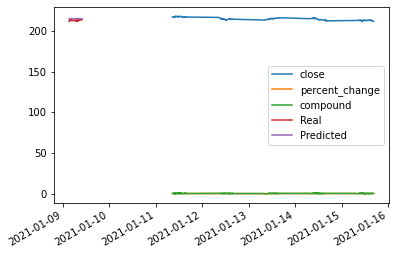

In [336]:
predicted_df = combined_df.append(stocks)
predicted_df.plot()